### Statical Analysis

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import shap 

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
# Import the modules
import data_processing as dp
import model as m
from utils import *
from datetime import datetime

In [4]:
df = pd.read_csv('../data/cleaned_df.csv')
pd.set_option('display.max_columns', None)

C:\Users\gtaye\AppData\Local\Temp\ipykernel_12860\3544251542.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/cleaned_df.csv')


In [5]:
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,MaritalStatus,Gender,Country,Province,PostalCode,MainCrestaZone,SubCrestaZone,ItemType,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,PremiumChange,ClaimChange
0,13562,443,2014-04-01 00:00:00,False,,Individual,Mr,English,1,2,South Africa,0,5470,"Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",Tembu 2,Mobility - Motor,60058418.0,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,4.0,2694.0,111.0,B/S,4.0,10/2010,Yes,No,0.0,0.01,Monthly,18.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,15.789474,0.0,NaN,NaN
1,13560,443,2014-04-01 00:00:00,False,,Individual,Mr,English,1,2,South Africa,0,5470,"Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",Tembu 2,Mobility - Motor,60058418.0,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,4.0,2694.0,111.0,B/S,4.0,10/2010,Yes,No,0.0,3500.00,Monthly,1.8744,No excess,Signage and Vehicle Wraps,Signage and Vehicle Wraps,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,1.644211,0.0,-14.145263,0.0
2,13557,443,2014-04-01 00:00:00,False,,Individual,Mr,English,1,2,South Africa,0,5470,"Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",Tembu 2,Mobility - Motor,60058418.0,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,4.0,2694.0,111.0,B/S,4.0,10/2010,Yes,No,0.0,7500.00,Monthly,5.6230,No excess,Emergency Charges,Emergency Charges,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,4.932456,0.0,3.288246,0.0
3,13567,443,2014-04-01 00:00:00,False,,Individual,Mr,English,1,2,South Africa,0,5470,"Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",Tembu 2,Mobility - Motor,60058418.0,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,4.0,2694.0,111.0,B/S,4.0,10/2010,Yes,No,0.0,146100.00,Monthly,548.9491,Mobility - Taxi with value more than R100 000 ...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,481.534298,0.0,476.601842,0.0
4,13556,443,2014-04-01 00:00:00,False,,Individual,Mr,English,1,2,South Africa,0,5470,"Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",Tembu 2,Mobility - Motor,60058418.0,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,4.0,2694.0,111.0,B/S,4.0,10/2010,Yes,No,0.0,500000.00,Monthly,196.8035,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,172.634649,0.0,-308.899649,0.0


In [6]:
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims', 'PremiumChange', 'ClaimChange'],
      dtype='object')

In [8]:
df['RegistrationYear'] = df['RegistrationYear'].astype('int')
df['PostalCode'] = df['PostalCode'].astype('int')

In [9]:
# Get the current year
current_year = datetime.now().year
# Calculate the age of the car
df['CarAge'] = current_year - df['RegistrationYear']

In [11]:
# Encode and scale the data
categorical_feature = ['Citizenship','LegalType',  'Gender', 'Province',  'ItemType','VehicleType', 'RegistrationYear', 'make', 'Model', 'CoverType', 'CoverGroup' , 'TermFrequency']
numerical_feature = ['CalculatedPremiumPerTerm', 'SumInsured',  'PostalCode','CarAge']
test_feature = ['TotalPremium', 'TotalClaims']
all_feature = categorical_feature + numerical_feature + test_feature
df_feat = df[all_feature]
df_feat.head()

,Citizenship,LegalType,Gender,Province,ItemType,VehicleType,RegistrationYear,make,Model,CoverType,CoverGroup,TermFrequency,CalculatedPremiumPerTerm,SumInsured,PostalCode,CarAge,TotalPremium,TotalClaims
0,,Individual,2,0,Mobility - Motor,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,Windscreen,Comprehensive - Taxi,Monthly,18.0000,0.01,5470,15,15.789474,0.0
1,,Individual,2,0,Mobility - Motor,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,Signage and Vehicle Wraps,Comprehensive - Taxi,Monthly,1.8744,3500.00,5470,15,1.644211,0.0
2,,Individual,2,0,Mobility - Motor,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,Emergency Charges,Comprehensive - Taxi,Monthly,5.6230,7500.00,5470,15,4.932456,0.0
3,,Individual,2,0,Mobility - Motor,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,Own Damage,Comprehensive - Taxi,Monthly,548.9491,146100.00,5470,15,481.534298,0.0
4,,Individual,2,0,Mobility - Motor,Passenger Vehicle,2009,TOYOTA,QUANTUM 2.7 SESFIKILE 15s,Third Party,Comprehensive - Taxi,Monthly,196.8035,500000.00,5470,15,172.634649,0.0


In [12]:
df_label = dp.encoder('oneHotEncoder', df_feat, categorical_feature)


In [13]:
df_scaled = dp.scaler('standardScaler', df_label, numerical_feature)

In [14]:
df_scaled[df_scaled.select_dtypes(include=['float64']).columns] = df_scaled.select_dtypes(include=['float64']).astype('float32')

In [15]:
# Split the data
X = df_scaled.drop(columns=['TotalPremium', 'TotalClaims'], axis=1)
y = df_scaled['TotalPremium']
X_train, X_test, y_train, y_test = m.split_data(X, y)

In [16]:
df_scaled.shape

(999253, 542)

In [17]:

df_scaled.head()

,CalculatedPremiumPerTerm,SumInsured,PostalCode,CarAge,TotalPremium,TotalClaims,ohe_AF,ohe_ZA,ohe_ZW,ohe_Individual,ohe_Partnership,ohe_Private company,ohe_Public company,ohe_Sole proprieter,ohe_1,ohe_2,ohe_1,ohe_2,ohe_3,ohe_4,ohe_5,ohe_6,ohe_7,ohe_8,ohe_Heavy Commercial,ohe_Light Commercial,ohe_Medium Commercial,ohe_Passenger Vehicle,ohe_1988,ohe_1992,ohe_1994,ohe_1995,ohe_1996,ohe_1997,ohe_1998,ohe_1999,ohe_2000,ohe_2001,ohe_2002,ohe_2003,ohe_2004,ohe_2005,ohe_2006,ohe_2007,ohe_2008,ohe_2009,ohe_2010,ohe_2011,ohe_2012,ohe_2013,ohe_2014,ohe_2015,ohe_B.A.W,ohe_BMW,ohe_C.A.M,ohe_CHERY,ohe_CHEVROLET,ohe_CITROEN,ohe_CMC,ohe_DAIHATSU,ohe_FIAT,ohe_FORD,ohe_FORD,ohe_FOTON,ohe_GEELY,ohe_GOLDEN JOURNEY,ohe_HINO,ohe_HONDA,ohe_HUMMER,ohe_HYUNDAI,ohe_IVECO,ohe_JINBEI,ohe_JINBEI,ohe_JMC,ohe_KIA,ohe_LEXUS,ohe_MAHINDRA,ohe_MARCOPOLO,ohe_MAZDA,ohe_MERCEDES-BENZ,ohe_MERCEDES-BENZ,ohe_MITSUBISHI,ohe_NISSAN,ohe_NISSAN/DATSUN,ohe_OPEL,ohe_PEUGEOT,ohe_POLARSUN,ohe_PROTON,ohe_RENAULT,ohe_SAIC,ohe_SCANIA,ohe_SUZUKI,ohe_TATA,ohe_TOYOTA,ohe_TOYOTA,ohe_VOLKSWAGEN,ohe_VOLVO,ohe_115 VITO 2.2 CDI CREW CAB F/C P/V,ohe_13-206 F/C C/C,ohe_1400 CHAMP (B01) P/U S/C,ohe_3 1.6 DYNAMIC,ohe_3 2.0 INDIVIDUAL,ohe_316i (E36),ohe_316i (F30),ohe_316i A/T (F30),ohe_318iS (E36),ohe_320d (E90),ohe_320d A/T (E90),ohe_320d START (E90),ohe_320i (E36),ohe_320i (E90),ohe_320i (F30),ohe_320i A/T (E90),ohe_320i START (E90),ohe_323 130 STING,ohe_325i (E46)F/L,ohe_328i (F30),ohe_330i (E90),ohe_35 S13V 7M F/C P/V,ohe_35 S13V 8 F/C P/V,ohe_35 S13V 9M F/C P/V,ohe_35S12V10 F/C P/V,ohe_35S12V12 F/C P/V,ohe_35S12V8 F/C P/V,ohe_35S15C CAMPER P/V,ohe_40 C11CC F/C C/C,ohe_5 2.0L ACTIVE,ohe_50 C13 F/C C/C,ohe_50 C13D F/C D/C,ohe_50 C13V 15M F/C P/V,ohe_50 C15V 15 F/C P/V,ohe_50C15 F/C C/C,ohe_50C15V12 F/C P/V,ohe_50C15V15 F/C P/V,ohe_523i A/T (E60),ohe_525i (E60),ohe_626 200 e,ohe_A4 1.8T AMBITION (B8),ohe_A4 1.8T AMBITION MULTITRONIC (B8),ohe_A4 1.8T ATTRACTION (B8),ohe_A4 1.8T S AVANT,ohe_A4 1.8T S AVANT MULTITRONIC,ohe_A4 2.0 (B7),ohe_A4 2.0 TDI AMBITION (B8),ohe_A4 2.0 TDI AMBITION 125KW (B8),ohe_A4 2.0 TDI S MULTITRONIC,ohe_A4 2.0 TDI S 105kW,ohe_A4 2.0 TDI SE MULTITRONIC,ohe_A4 3.0 TDI AVANT QUAT TIP (B7),ohe_A4 3.0 TDI QUATTRO (B7),ohe_A5 SPRTBACK 2.0 TDI MULTI,ohe_ACCENT 1.5 CSi,ohe_ACCENT 1.5 RSi,ohe_ACCORD 2.0i A/T,ohe_ALMERA 1.5 ACENTA,ohe_ALMERA 1.6 COMFORT (H01),ohe_ALMERA 1.6 COMFORT (H14/25),ohe_ALMERA 1.6 LUXURY (H02),ohe_ALMERA 1.6 LUXURY (H15/H26),ohe_ALMERA 1.6 LUXURY A/T (H16/27),ohe_AMANDLA 2.2,ohe_ATEGO 1217/48 F/C C/C,ohe_AURIS 1.6 XS,ohe_AVANZA 1.3 S,ohe_AVANZA 1.3 S,ohe_AVANZA 1.3 S F/C P/V,ohe_AVANZA 1.3 SX,ohe_AVANZA 1.5 SX,ohe_AVANZA 1.5 SX A/T,ohe_AVANZA 1.5 TX,ohe_AVENSIS 2.0 ADVANCED,ohe_AVEO 1.5 LS 5Dr A/T,ohe_BALLADE 180 E A/T,ohe_BANTAM 1.3i A/C P/U S/C,ohe_BOXER L2H1 2.2 HDi M F/C P/V,ohe_BOXER L4H2 2.2 HDi XLH4 F/C P/V,ohe_BOXER L4H2 3.0 HDi XLH4 F/C P/V,ohe_C180,ohe_C180 A/T,ohe_C180 BE COUPE,ohe_C180 BE COUPE A/T,ohe_C180 CGI BE CLASSIC,ohe_C180 CGI BE CLASSIC A/T,ohe_C180 ESTATE,ohe_C180 ESTATE A/T,ohe_C180K BE AVANTGARDE,ohe_C180K CLASSIC,ohe_C180K CLASSIC A/T,ohe_C200 BE CLASSIC,ohe_C200 BE CLASSIC A/T,ohe_C200 BE ESTATE CLASSIC,ohe_C200 CDi CLASSIC A/T,ohe_C200 CDi ESTATE CLASSIC A/T,ohe_C200 CGI BE CLASSIC,ohe_C200 CGI BE CLASSIC A/T,ohe_C200K CLASSIC,ohe_C200K CLASSIC A/T,ohe_C200K ESTATE CLASSIC,ohe_C220 CDi CLASSIC,ohe_C230 CLASSIC A/T,ohe_C350 CDI ELEGANCE A/T,ohe_C350 CDi BE ELEGANCE A/T,ohe_CADDY KOMBI 1.9 TDi,ohe_CADDY MAXI 2.0TDi (81KW) CREWBUS P/V,ohe_CADDY MAXI CREW BUS 1.9TDi,ohe_CAMRY 200 Si A/T,ohe_CAMRY 220 GX A/T,ohe_CANTER 2.4P 3.0 TONNE F/C C/C,ohe_CARAVELLE 2.6i A/C P/S,ohe_CARRYING 2.8 TDi 1.6 TON LUX SWB D/,ohe_CERATO 1.6 5DR,ohe_CERATO 1.6 5Dr,ohe_CERATO 1.6 A/T,ohe_CITI CHICO 1.6i,ohe_CITI.COM 1.4i,ohe_CIVIC 1.8 COMFORT A/T,ohe_CONDOR 1800,ohe_CONDOR 1800 ESTATE,ohe_CONDOR 2000i ESTATE,ohe_CONDOR 2000i ESTATE TE,ohe_CONDOR 2400i 4X4 TX,ohe_CONDOR 2400i ESTATE,ohe_CONDOR 2400i ESTATE TE,ohe_CONDOR 3000D ESTATE,ohe_CONDOR 3000D

In [18]:
def train_models(X_train, y_train):
    # Initialize the models
    lr_model = LinearRegression()
    dt_model = DecisionTreeRegressor(random_state=42)
    rfr_model = RandomForestRegressor(random_state=42)
    xgb_model = xgb.XGBRegressor(random_state=42)
    
    # Train the models
    lr_model.fit(X_train, y_train)
    dt_model.fit(X_train, y_train)
    rfr_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    
    return lr_model, dt_model, rfr_model, xgb_model

In [19]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [20]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Higher Computational cost



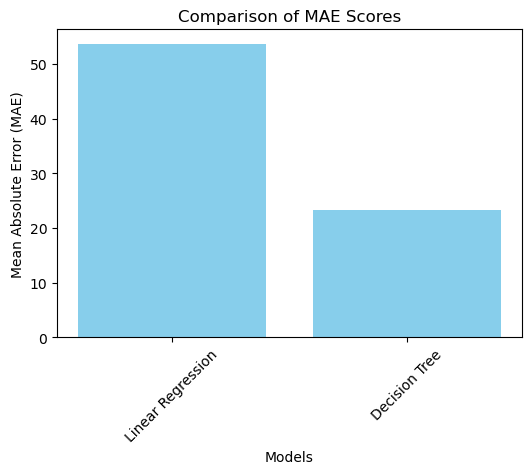

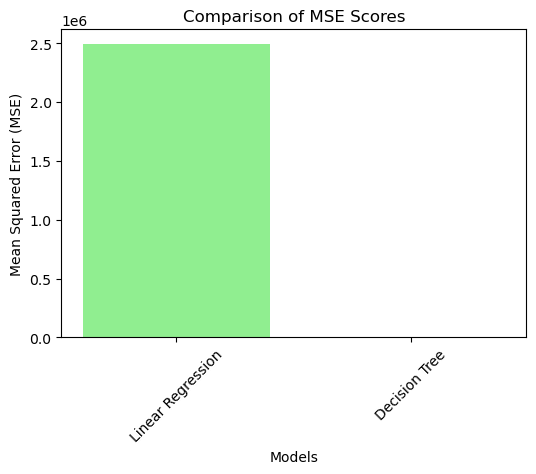

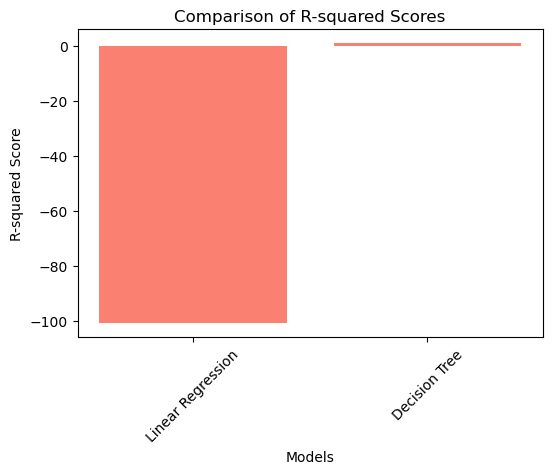

In [21]:
# Evaluate models
models = ['Linear Regression', 'Decision Tree']
mae_scores, mse_scores, r2_scores = [], [], []
for model in [lr_model, dt_model]:
    mae, mse, r2, _ = m.evaluate_model(model, X_test, y_test)
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Plot metrics
m.plot_metrics(models, mae_scores, mse_scores, r2_scores)